C:\Users\PC\AppData\Local\Temp\ipykernel_18776\2612627894.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", progress=False)


Epoch 1/50


C:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0011 - val_loss: 0.0272
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.0831e-04 - val_loss: 0.0275
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.5025e-04 - val_loss: 0.0120
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.3789e-04 - val_loss: 0.0106
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.0023e-04 - val_loss: 0.0106
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.9908e-04 - val_loss: 0.0047
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.7229e-04 - val_loss: 0.0047
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.5942e-04 - val_loss: 0.0081
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.5961e-04 - val_loss: 0.0089
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.4698e-04 - val_loss: 0.0053
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.4084e-04 - val_loss: 0.0082
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━

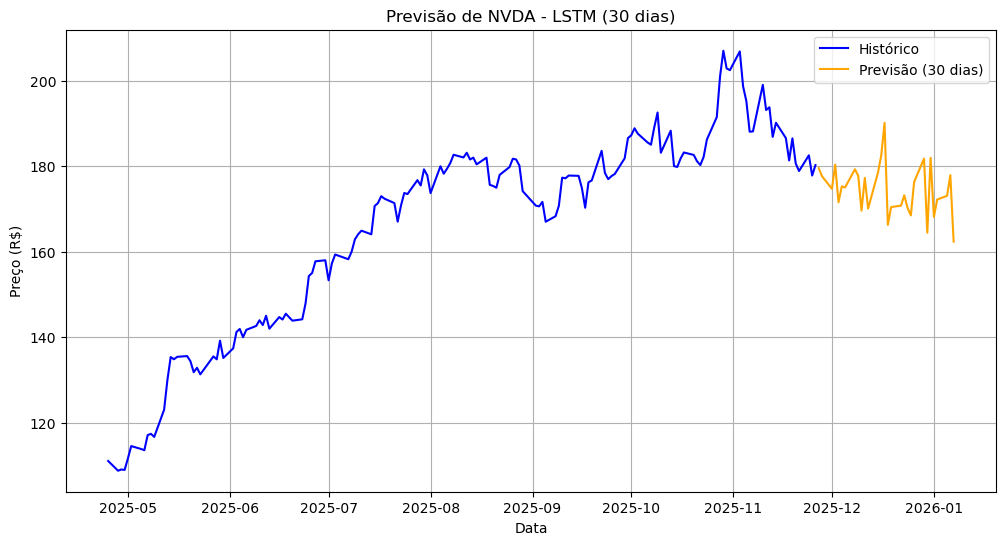

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
🔹 RMSE no conjunto de teste: 0.066976

 Previsão concluída!
Último preço real: R$ 180.26
Preço previsto em 30 dias: R$ 162.34


In [5]:
#DISCLAIMER: Aviso de isenção de responsabilidade
#Esse projeto é apenas um teste do meu aprendizado e os resultados não devem ser usados como conselhos financeiros ou recomendação de investimento. 
#Nesse projeto eu implemente um modelo LSTM simples, para tentar prever o preço de um ativo nos proximos 30 dias. 
#Modelos de machine learning possuem limitações que podem gerar erros significavos.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# DOWNLOAD DOS DADOS
ticker = "NVDA"   # mude aqui se quiser outro ativo
data = yf.download(ticker, start="2015-01-01", progress=False)
data = data[['Close', 'Volume']]
data.dropna(inplace=True)

# Indicadores simples
data['Return'] = data['Close'].pct_change()
data['MA7'] = data['Close'].rolling(window=7).mean()
data['MA21'] = data['Close'].rolling(window=21).mean()
data['Volatility'] = data['Return'].rolling(window=7).std()
data = data.dropna()

# NORMALIZAÇÃO
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# PREPARAR DADOS PARA LSTM
seq_len = 60
future_days = 30

X, y = [], []
for i in range(seq_len, len(scaled_data) - future_days):
    X.append(scaled_data[i-seq_len:i])
    y.append(scaled_data[i:i+future_days, 0])  # apenas o preço de fechamento
X, y = np.array(X), np.array(y)

# Split treino/teste mantendo ordem temporal
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# MODELO LSTM EMPILHADO
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(30)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# TREINAMENTO
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# PREVISÃO MULTI-STEP REAL
last_sequence = scaled_data[-seq_len:]
last_sequence = np.expand_dims(last_sequence, axis=0)

predicted_scaled = model.predict(last_sequence)
predicted_prices = scaler.inverse_transform(
    np.concatenate([predicted_scaled[0].reshape(-1,1),
                    np.zeros((future_days, scaled_data.shape[1]-1))], axis=1)
)[:,0]

# PLOTAGEM
last_date = data.index[-1]
future_dates = pd.date_range(last_date, periods=future_days+1, freq='B')[1:]

plt.figure(figsize=(12,6))
plt.plot(data.index[-150:], data['Close'].iloc[-150:], label="Histórico", color='blue')
plt.plot(future_dates, predicted_prices, label="Previsão (30 dias)", color='orange')
plt.title(f"Previsão de {ticker} - LSTM (30 dias)")
plt.xlabel("Data")
plt.ylabel("Preço (R$)")
plt.legend()
plt.grid(True)
plt.show()

# MÉTRICAS DE ERRO
pred_test = model.predict(X_test)
rmse = np.sqrt(np.mean((pred_test - y_test)**2))
print(f"🔹 RMSE no conjunto de teste: {rmse:.6f}")

print("\n Previsão concluída!")
ultimo_preco_real = data['Close'].iloc[-1].item()
ultimo_preco_previsto = predicted_prices[-1]

print(f"Último preço real: R$ {ultimo_preco_real:.2f}")
print(f"Preço previsto em 30 dias: R$ {ultimo_preco_previsto:.2f}")